In [1]:
%pip install scikit-learn
%pip install pandas
%pip install numpy
%pip install matplotlib



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

url = (
    "https://erddap.aoml.noaa.gov/gdp/erddap/tabledap/drifter_6hour_qc.csv?"
    "ID,time,latitude,lon360,ve,vn&"
    "time%3E%3D2010-01-01T00%3A00%3A00Z&time%3C%3D2010-12-31T23%3A59%3A59Z&"
    "latitude%3E%3D14&latitude%3C%3D32&lon360%3E%3D255&lon360%3C%3D300"
)
df_raw = pd.read_csv(url)
df = df_raw[pd.to_numeric(df_raw['latitude'], errors='coerce').notnull()].copy()
features = ['latitude', 'lon360', 've', 'vn']
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])
print("Data shape:", df_scaled.shape)
print("Unique drifters:", df_scaled['ID'].nunique())
print(df_scaled.head())
print(df_scaled[features].describe())


Data shape: (60423, 6)
Unique drifters: 137
        ID                  time  latitude    lon360        ve        vn
1  39092.0  2010-12-28T00:00:00Z  1.723621  1.207319  0.048190  0.048186
2  39092.0  2010-12-28T06:00:00Z  1.708624  1.205379  0.048190  0.048184
3  39092.0  2010-12-28T12:00:00Z  1.692627  1.204869  0.048193  0.048184
4  39092.0  2010-12-28T18:00:00Z  1.676130  1.207727  0.048195  0.048182
5  39092.0  2010-12-29T00:00:00Z  1.652634  1.211709  0.048194  0.048181
           latitude        lon360            ve            vn
count  6.042300e+04  6.042300e+04  6.042300e+04  6.042300e+04
mean  -4.703790e-18  4.545743e-15 -7.055685e-18  7.526064e-18
std    1.000008e+00  1.000008e+00  1.000008e+00  1.000008e+00
min   -2.770827e+00 -2.447809e+00 -2.075073e+01 -2.075073e+01
25%   -5.679700e-01 -8.422337e-01  4.818794e-02  4.818799e-02
50%    1.459026e-01  2.697505e-01  4.819096e-02  4.819083e-02
75%    7.018034e-01  8.437865e-01  4.819402e-02  4.819374e-02
max    1.728120e+00  1

In [4]:
num_drifters = df_scaled['ID'].nunique()
print(f"There are {num_drifters} unique drifters in the dataset.")


There are 137 unique drifters in the dataset.


In [11]:
%pip install kneed


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import numpy as np
import pandas as pd

features = ['latitude', 'lon360', 've', 'vn']
all_results = []
for drifter_id in df_scaled['ID'].unique():
    df_d = df_scaled[df_scaled['ID'] == drifter_id].copy()
    df_d = df_d.dropna(subset=features)
    if len(df_d) < 10:
        continue
    X = df_d[features].values
    X_scaled = StandardScaler().fit_transform(X)

    min_samples = 3
    k = min_samples - 1

    neighbors = NearestNeighbors(n_neighbors=k + 1)
    neighbors_fit = neighbors.fit(X_scaled)
    distances, indices = neighbors_fit.kneighbors(X_scaled)
    k_distances = np.sort(distances[:, k])
    try:
        kneedle = KneeLocator(range(len(k_distances)), k_distances, curve='convex', direction='increasing')
        eps_optimal = k_distances[kneedle.knee] if kneedle.knee is not None else 0.5
    except:
        eps_optimal = 0.5

    dbscan = DBSCAN(eps=eps_optimal, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    df_d['cluster'] = labels
    df_d['is_anomaly'] = labels == -1
    df_d['eps_used'] = eps_optimal
    all_results.append(df_d)

df_all_drifters_labeled = pd.concat(all_results, ignore_index=True)


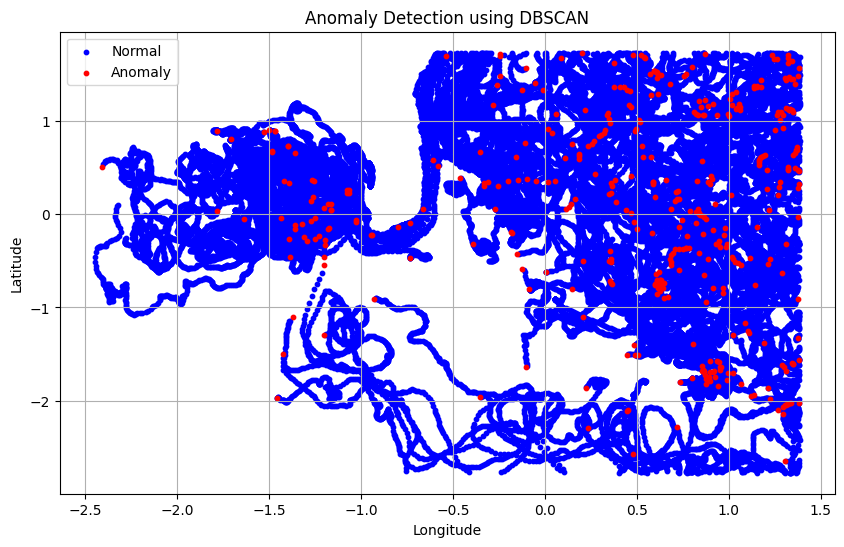

In [ ]:
plt.figure(figsize=(10, 6))
normal = df_all_drifters_labeled[df_all_drifters_labeled['is_anomaly'] == False]
anomaly = df_all_drifters_labeled[df_all_drifters_labeled['is_anomaly'] == True]
plt.scatter(normal['lon360'], normal['latitude'], c='blue', s=10, label='Normal')
plt.scatter(anomaly['lon360'], anomaly['latitude'], c='red', s=10, label='Anomaly')
plt.title('Anomaly Detection using DBSCAN')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
num_anomalies = df_all_drifters_labeled['is_anomaly'].sum()
print(f"Number of DBSCAN anomalies detected: {num_anomalies}")


Number of DBSCAN anomalies detected: 427


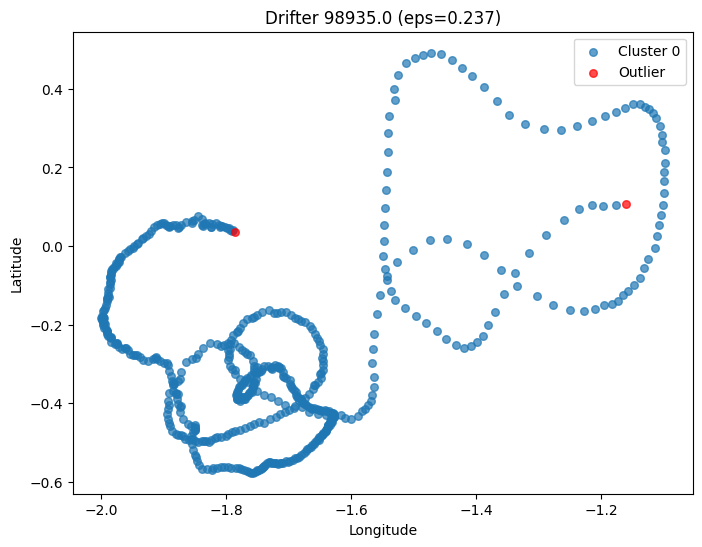

In [15]:
example_id = df_all_drifters_labeled['ID'].sample(1).values[0]
df_example = df_all_drifters_labeled[df_all_drifters_labeled['ID'] == example_id]

plt.figure(figsize=(8, 6))
for label in set(df_example['cluster']):
    mask = df_example['cluster'] == label
    color = 'red' if label == -1 else None
    plt.scatter(df_example[mask]['lon360'], df_example[mask]['latitude'],
                label='Outlier' if label == -1 else f'Cluster {label}', s=30, alpha=0.7, c=color)
    
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Drifter {example_id} (eps={df_example['eps_used'].iloc[0]:.3f})")
plt.legend()
plt.show()


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from tensorflow.keras import layers, models, callbacks, backend as K
import matplotlib.pyplot as plt
import pandas as pd

def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

features = ['latitude', 'lon360', 've', 'vn']
window_size = 10
stride = 1
X_seq, y_seq = [], []
for drifter_id in df_all_drifters_labeled['ID'].unique():
    df_drifter = df_all_drifters_labeled[df_all_drifters_labeled['ID'] == drifter_id]
    df_drifter = df_drifter.dropna(subset=features + ['is_anomaly'])
    if len(df_drifter) < window_size:
        continue
    values = df_drifter[features].values
    labels = df_drifter['is_anomaly'].values
    for i in range(0, len(values) - window_size + 1, stride):
        X_seq.append(values[i:i + window_size])
        y_seq.append(int(np.max(labels[i:i + window_size])))

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
print(f"X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}, Total anomalies: {np.sum(y_seq)}")

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return alpha * K.pow(1 - p_t, gamma) * bce
    return loss

def build_cnn(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def evaluate_metrics(y_true, y_pred_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    y_pred = (y_pred_probs >= best_thresh).astype(int)
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred_probs),
        'pr_auc': auc(recalls, precisions),
        'best_thresh': best_thresh
    }
    cm = confusion_matrix(y_true, y_pred)
    return metrics, cm

def run_experiment(X_seq, y_seq, test_size=0.2, n_runs=10, epochs=20, batch_size=64):
    all_metrics = []
    all_cms = []
    for run_idx in range(n_runs):
        seed = 1000 + run_idx
        set_seed(seed)
        X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
            X_seq, y_seq, test_size=test_size, random_state=seed, stratify=y_seq
        )
        X_pos = X_train_seq[y_train_seq == 1]
        y_pos = y_train_seq[y_train_seq == 1]
        X_neg = X_train_seq[y_train_seq == 0]
        y_neg = y_train_seq[y_train_seq == 0]
        X_pos_upsampled, y_pos_upsampled = resample(
            X_pos, y_pos, replace=True, n_samples=len(y_neg), random_state=seed
        )
        X_train_bal = np.concatenate([X_neg, X_pos_upsampled])
        y_train_bal = np.concatenate([y_neg, y_pos_upsampled])
        shuffle_idx = np.random.permutation(len(X_train_bal))
        X_train_bal, y_train_bal = X_train_bal[shuffle_idx], y_train_bal[shuffle_idx]

        alpha = 1 - np.mean(y_train_bal)
        model = build_cnn((X_train_bal.shape[1], X_train_bal.shape[2]))
        model.compile(
            optimizer='adam',
            loss=focal_loss(alpha=alpha, gamma=1.0),
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
        )
        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
        model.fit(
            X_train_bal, y_train_bal,
            validation_data=(X_val_seq, y_val_seq),
            epochs=epochs, batch_size=batch_size,
            callbacks=[early_stop],
            verbose=0
        )
        y_val_probs = model.predict(X_val_seq, verbose=0).ravel()
        metrics, cm = evaluate_metrics(y_val_seq, y_val_probs)
        metrics['seed'] = seed
        all_metrics.append(metrics)
        all_cms.append(cm)
        print(f"Run {run_idx+1}/{n_runs}, Seed {seed}, Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}")
    return all_metrics, all_cms

def average_confusion_matrices(cms):
    sum_cm = np.zeros_like(cms[0], dtype=float)
    for cm in cms:
        sum_cm += cm
    return sum_cm / len(cms)

n_runs = 10
metrics_cnn, cms_cnn = run_experiment(X_seq, y_seq, test_size=0.2, n_runs=n_runs)
avg_cm_cnn = average_confusion_matrices(cms_cnn)
df_metrics_cnn = pd.DataFrame(metrics_cnn)
print("Average Confusion Matrix (80/20 CNN):\n", avg_cm_cnn)
print("\nPer-run metrics:\n", df_metrics_cnn)


X_seq shape: (59198, 10, 4), y_seq shape: (59198,), Total anomalies: 1609


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-18 01:11:27.362724: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-10-18 01:11:27.362752: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-18 01:11:27.362787: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-18 01:11:27.362818: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-18 01:11:27.362836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device

Run 1/10, Seed 1000, Acc=0.934, F1=0.206


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 2/10, Seed 1001, Acc=0.943, F1=0.207


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 3/10, Seed 1002, Acc=0.969, F1=0.318


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 4/10, Seed 1003, Acc=0.946, F1=0.224


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 5/10, Seed 1004, Acc=0.974, F1=0.182


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 6/10, Seed 1005, Acc=0.974, F1=0.187


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 7/10, Seed 1006, Acc=0.952, F1=0.194


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 8/10, Seed 1007, Acc=0.920, F1=0.223


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 9/10, Seed 1008, Acc=0.961, F1=0.188


/Users/candy/finalproject/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run 10/10, Seed 1009, Acc=0.964, F1=0.182
Average Confusion Matrix (80/20 CNN):
 [[11215.9   302.1]
 [  247.6    74.4]]

Per-run metrics:
    accuracy  precision    recall        f1   roc_auc    pr_auc  best_thresh  \
0  0.933784   0.153153  0.316770  0.206478  0.864936  0.200565     0.685218   
1  0.943074   0.166667  0.273292  0.207059  0.849980  0.195646     0.648974   
2  0.969257   0.400943  0.263975  0.318352  0.861456  0.296704     0.642034   
3  0.945608   0.183071  0.288820  0.224096  0.881354  0.207086     0.675865   
4  0.974240   0.666667  0.105590  0.182306  0.818703  0.185622     0.753634   
5  0.973564   0.571429  0.111801  0.187013  0.824351  0.189178     0.708234   
6  0.952196   0.178947  0.211180  0.193732  0.835237  0.184126     0.668633   
7  0.919848   0.151279  0.422360  0.222768  0.871833  0.221709     0.634804   
8  0.960642   0.214286  0.167702  0.188153  0.806588  0.183555     0.651823   
9  0.963514   0.233010  0.149068  0.181818  0.818253  0.185155     0.67

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc
)
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

features = ['latitude', 'lon360', 've', 'vn']
window_size = 10
stride = 1
X_seq, y_seq = [], []
for drifter_id in df_all_drifters_labeled['ID'].unique():
    df_drifter = df_all_drifters_labeled[df_all_drifters_labeled['ID'] == drifter_id]
    df_drifter = df_drifter.dropna(subset=features + ['is_anomaly'])
    if len(df_drifter) < window_size:
        continue
    values = df_drifter[features].values
    labels = df_drifter['is_anomaly'].values
    for i in range(0, len(values) - window_size + 1, stride):
        X_seq.append(values[i:i + window_size])
        y_seq.append(int(np.max(labels[i:i + window_size])))

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
print(f"Sliding windows: {X_seq.shape}, labels: {y_seq.shape}, Total anomalies: {np.sum(y_seq)}")
X_mean = np.mean(X_seq, axis=1)
X_std = np.std(X_seq, axis=1)
X_max = np.max(X_seq, axis=1)
X_min = np.min(X_seq, axis=1)
X_agg = np.concatenate([X_mean, X_std, X_max, X_min], axis=1)
seeds = list(range(10))
all_metrics_lr = []

for seed in seeds:
    set_seed(seed)
    X_train, X_val, y_train, y_val = train_test_split(
        X_agg, y_seq, test_size=0.2, stratify=y_seq, random_state=seed
    )
    X_pos = X_train[y_train==1]
    y_pos = y_train[y_train==1]
    X_neg = X_train[y_train==0]
    y_neg = y_train[y_train==0]
    if len(X_pos) > 0:
        X_pos_upsampled, y_pos_upsampled = resample(
            X_pos, y_pos, replace=True, n_samples=len(y_neg), random_state=seed
        )
        X_train_bal = np.concatenate([X_neg, X_pos_upsampled])
        y_train_bal = np.concatenate([y_neg, y_pos_upsampled])
    else:
        X_train_bal, y_train_bal = X_train, y_train 
    shuffle_idx = np.random.permutation(len(X_train_bal))
    X_train_bal, y_train_bal = X_train_bal[shuffle_idx], y_train_bal[shuffle_idx]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_bal)
    X_val_scaled = scaler.transform(X_val)
    model_lr = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000, random_state=seed)
    model_lr.fit(X_train_scaled, y_train_bal)
    y_val_probs = model_lr.predict_proba(X_val_scaled)[:, 1]
    
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx] if len(thresholds) > 0 else 0.5
    y_val_pred = (y_val_probs >= best_thresh).astype(int)

    metrics = {
        'seed': seed,
        'accuracy': accuracy_score(y_val, y_val_pred),
        'precision': precision_score(y_val, y_val_pred, zero_division=0),
        'recall': recall_score(y_val, y_val_pred, zero_division=0),
        'f1': f1_score(y_val, y_val_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_val, y_val_probs),
        'pr_auc': auc(recalls, precisions),
        'best_thresh': best_thresh
    }
    all_metrics_lr.append(metrics)
    print(f"Seed {seed} done: Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}")
df_metrics_lr = pd.DataFrame(all_metrics_lr)
print(df_metrics_lr.describe())


Sliding windows: (59198, 10, 4), labels: (59198,), Total anomalies: 1609
Seed 0 done: Acc=0.960, F1=0.256
Seed 1 done: Acc=0.962, F1=0.266
Seed 2 done: Acc=0.960, F1=0.239
Seed 3 done: Acc=0.960, F1=0.254
Seed 4 done: Acc=0.961, F1=0.250
Seed 5 done: Acc=0.958, F1=0.272
Seed 6 done: Acc=0.958, F1=0.220
Seed 7 done: Acc=0.961, F1=0.283
Seed 8 done: Acc=0.959, F1=0.258
Seed 9 done: Acc=0.962, F1=0.244
           seed   accuracy  precision     recall         f1    roc_auc  \
count  10.00000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    4.50000   0.960008   0.258413   0.250932   0.254271   0.839408   
std     3.02765   0.001553   0.017697   0.022337   0.017505   0.007886   
min     0.00000   0.957601   0.220497   0.220497   0.220497   0.825287   
25%     2.25000   0.958889   0.252659   0.232919   0.245711   0.834171   
50%     4.50000   0.960304   0.258095   0.251553   0.254909   0.841256   
75%     6.75000   0.961254   0.263305   0.261646   0.264069   0.843429   
max  

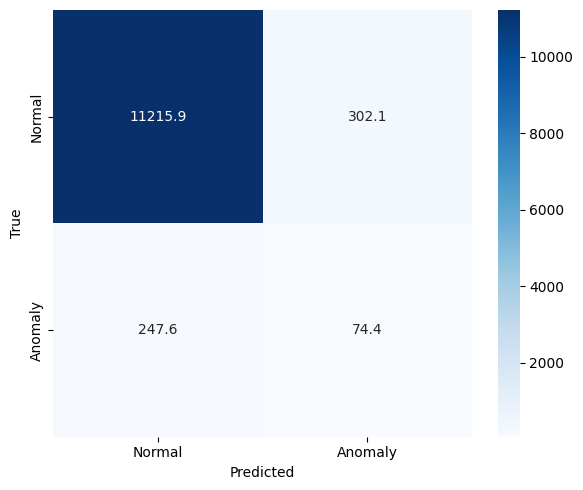

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = np.array([[11215.9, 302.1],
                        [247.6, 74.4]])

labels = ['Normal', 'Anomaly']
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [ ]:
def build_lstm(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs)

def run_experiment_lstm(X_seq, y_seq, test_size=0.2, n_runs=10, epochs=20, batch_size=64):
    all_metrics = []
    all_cms = []
    for run_idx in range(n_runs):
        seed = 2000 + run_idx 
        set_seed(seed)
        X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
            X_seq, y_seq, test_size=test_size, random_state=seed, stratify=y_seq
        )

        X_pos = X_train_seq[y_train_seq == 1]
        y_pos = y_train_seq[y_train_seq == 1]
        X_neg = X_train_seq[y_train_seq == 0]
        y_neg = y_train_seq[y_train_seq == 0]
        X_pos_upsampled, y_pos_upsampled = resample(
            X_pos, y_pos, replace=True, n_samples=len(y_neg), random_state=seed
        )
        X_train_bal = np.concatenate([X_neg, X_pos_upsampled])
        y_train_bal = np.concatenate([y_neg, y_pos_upsampled])
        shuffle_idx = np.random.permutation(len(X_train_bal))
        X_train_bal, y_train_bal = X_train_bal[shuffle_idx], y_train_bal[shuffle_idx]

        alpha = 1 - np.mean(y_train_bal)
        input_shape = (X_train_bal.shape[1], X_train_bal.shape[2])
        model = build_lstm(input_shape)
        model.compile(
            optimizer='adam',
            loss=focal_loss(alpha=alpha, gamma=1.0),
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
        )
        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
        model.fit(
            X_train_bal, y_train_bal,
            validation_data=(X_val_seq, y_val_seq),
            epochs=epochs, batch_size=batch_size,
            callbacks=[early_stop],
            verbose=0
        )
        y_val_probs = model.predict(X_val_seq, verbose=0).ravel()
        metrics, cm = evaluate_metrics(y_val_seq, y_val_probs)
        metrics['seed'] = seed
        all_metrics.append(metrics)
        all_cms.append(cm)
        print(f"LSTM Run {run_idx+1}/{n_runs}, Seed {seed}, Acc={metrics['accuracy']:.3f}, F1={metrics['f1']:.3f}")
    return all_metrics, all_cms

metrics_lstm, cms_lstm = run_experiment_lstm(X_seq, y_seq, test_size=0.2, n_runs=n_runs)
avg_cm_lstm = average_confusion_matrices(cms_lstm)
df_metrics_lstm = pd.DataFrame(metrics_lstm)
print("Average Confusion Matrix (80/20 LSTM):\n", avg_cm_lstm)
print("\nPer-run metrics (LSTM):\n", df_metrics_lstm)


LSTM Run 1/10, Seed 2000, Acc=0.970, F1=0.253
LSTM Run 2/10, Seed 2001, Acc=0.959, F1=0.229
LSTM Run 3/10, Seed 2002, Acc=0.968, F1=0.169
LSTM Run 4/10, Seed 2003, Acc=0.916, F1=0.167
LSTM Run 5/10, Seed 2004, Acc=0.945, F1=0.265
LSTM Run 6/10, Seed 2005, Acc=0.963, F1=0.287
LSTM Run 7/10, Seed 2006, Acc=0.975, F1=0.240
LSTM Run 8/10, Seed 2007, Acc=0.974, F1=0.274
LSTM Run 9/10, Seed 2008, Acc=0.970, F1=0.278
LSTM Run 10/10, Seed 2009, Acc=0.945, F1=0.257
Average Confusion Matrix (80/20 LSTM):
 [[11269.9   248.1]
 [  245.5    76.5]]

Per-run metrics (LSTM):
    accuracy  precision    recall        f1   roc_auc    pr_auc  best_thresh  \
0  0.970017   0.392157  0.186335  0.252632  0.883540  0.235285     0.761380   
1  0.958530   0.231746  0.226708  0.229199  0.848699  0.201098     0.670890   
2  0.967568   0.278571  0.121118  0.168831  0.807765  0.158262     0.643637   
3  0.915709   0.114155  0.310559  0.166945  0.835235  0.137292     0.624368   
4  0.945186   0.208556  0.363354  0.265

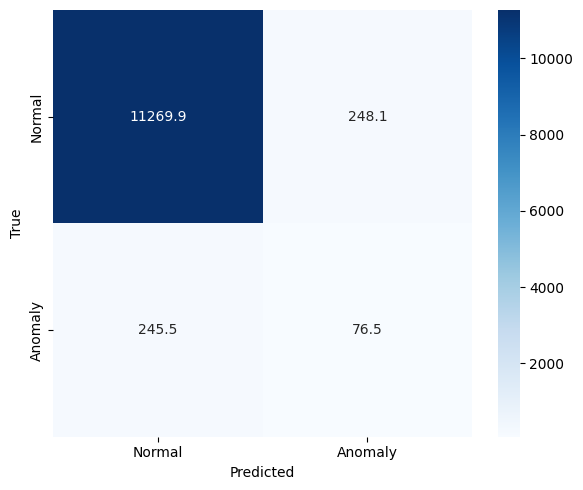

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = np.array([[11269.9, 248.1],
                        [245.5, 76.5]])

labels = ['Normal', 'Anomaly']
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


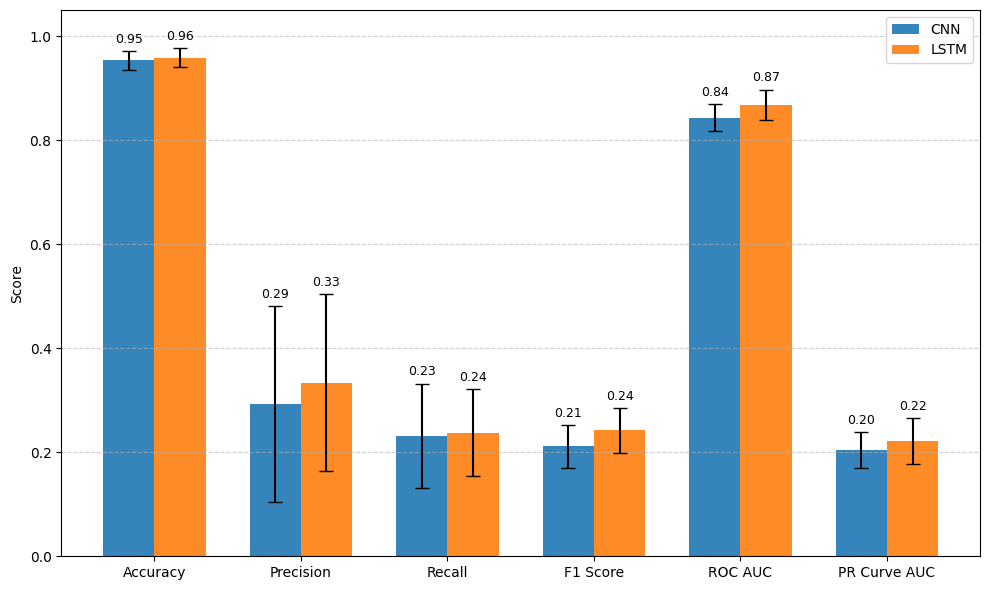

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'PR Curve AUC']

cnn_means = [df_metrics_cnn[m].mean() for m in metrics_to_plot]
cnn_stds = [df_metrics_cnn[m].std() for m in metrics_to_plot]
lstm_means = [df_metrics_lstm[m].mean() for m in metrics_to_plot]
lstm_stds = [df_metrics_lstm[m].std() for m in metrics_to_plot]

x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, cnn_means, width, yerr=cnn_stds, capsize=5, label='CNN', color='#1f77b4', alpha=0.9)
bars2 = plt.bar(x + width/2, lstm_means, width, yerr=lstm_stds, capsize=5, label='LSTM', color='#ff7f0e', alpha=0.9)
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.xticks(x, labels)
plt.legend()

for bars, means, stds in zip([bars1, bars2], [cnn_means, lstm_means], [cnn_stds, lstm_stds]):
    for bar, mean, std in zip(bars, means, stds):
        offset = std + 0.01
        plt.annotate(f'{mean:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, mean + offset),
                     xytext=(0, 0),
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


95% CI for mean difference (CNN - LSTM): [-0.0703, 0.0181]
Observed mean difference         : -0.0307


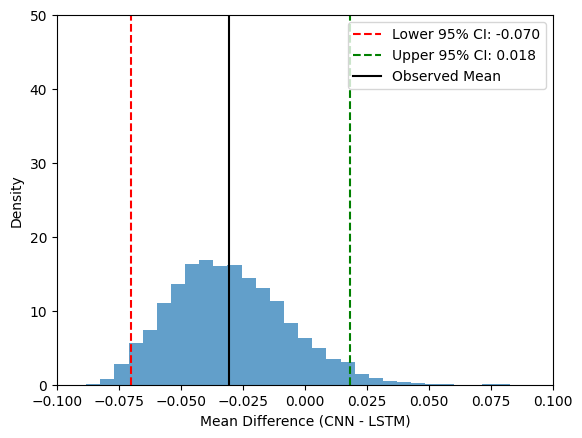

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

f1_cnn = df_metrics_cnn['f1'].values
f1_lstm = df_metrics_lstm['f1'].values
assert f1_cnn.shape == f1_lstm.shape, "CNN and LSTM arrays must be same length"
N = len(f1_cnn)

def shuffle_in_blocks(arr1, arr2, block_size):
    n = len(arr1)
    n_blocks = n // block_size
    leftover = n % block_size
    b1 = arr1[:n_blocks*block_size].reshape(n_blocks, block_size)
    b2 = arr2[:n_blocks*block_size].reshape(n_blocks, block_size)
    perm = np.random.permutation(n_blocks)
    s1 = b1[perm].reshape(-1)
    s2 = b2[perm].reshape(-1)
    if leftover:
        s1 = np.concatenate([s1, arr1[-leftover:]])
        s2 = np.concatenate([s2, arr2[-leftover:]])

    return s1, s2

def bootstrap_mean_diff(arr1, arr2, block_size=2, n_boot=5000, ci=95):
    diffs = np.empty(n_boot)
    n = len(arr1)
    for i in range(n_boot):
        s1, s2 = shuffle_in_blocks(arr1, arr2, block_size)
        idx = np.random.choice(n, n, replace=True)
        diffs[i] = np.mean(s1[idx] - s2[idx])
    lower = np.percentile(diffs, (100 - ci) / 2)
    upper = np.percentile(diffs, 100 - (100 - ci) / 2)
    obs_diff = np.mean(arr1 - arr2)
    print(f"{ci}% CI for mean difference (CNN - LSTM): [{lower:.4f}, {upper:.4f}]")
    print(f"Observed mean difference         : {obs_diff:.4f}")
    return diffs, lower, upper

boot_diffs, ci_lo, ci_hi = bootstrap_mean_diff(f1_cnn, f1_lstm, block_size=2, n_boot=5000)
plt.hist(boot_diffs, bins=30, density=True, alpha=0.7)
plt.axvline(ci_lo, color='red', linestyle='--', label=f"Lower 95% CI: {ci_lo:.3f}")
plt.axvline(ci_hi, color='green', linestyle='--', label=f"Upper 95% CI: {ci_hi:.3f}")
plt.axvline(np.mean(f1_cnn - f1_lstm), color='black', linestyle='-', label="Observed Mean")
plt.xlim(-0.1, 0.1)
plt.ylim(0,50)
plt.xlabel("Mean Difference (CNN - LSTM)")
plt.ylabel("Density")
plt.legend()
plt.show()
